In [1]:
# df.createOrReplaceTempView("df")
# spark.sql("SELECT * FROM df").show()

In [2]:
!pip install pyspark_dist_explore matplotlib


In [3]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


spark = SparkSession.builder.appName("League_Winner_Prediction").getOrCreate()

file_path = 'C:/Users/48692/Desktop/BIG DATA PROJECT/high_diamond_ranked_10min.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()
# df.show(5)


root
 |-- gameId: long (nullable = true)
 |-- blueWins: integer (nullable = true)
 |-- blueWardsPlaced: integer (nullable = true)
 |-- blueWardsDestroyed: integer (nullable = true)
 |-- blueFirstBlood: integer (nullable = true)
 |-- blueKills: integer (nullable = true)
 |-- blueDeaths: integer (nullable = true)
 |-- blueAssists: integer (nullable = true)
 |-- blueEliteMonsters: integer (nullable = true)
 |-- blueDragons: integer (nullable = true)
 |-- blueHeralds: integer (nullable = true)
 |-- blueTowersDestroyed: integer (nullable = true)
 |-- blueTotalGold: integer (nullable = true)
 |-- blueAvgLevel: double (nullable = true)
 |-- blueTotalExperience: integer (nullable = true)
 |-- blueTotalMinionsKilled: integer (nullable = true)
 |-- blueTotalJungleMinionsKilled: integer (nullable = true)
 |-- blueGoldDiff: integer (nullable = true)
 |-- blueExperienceDiff: integer (nullable = true)
 |-- blueCSPerMin: double (nullable = true)
 |-- blueGoldPerMin: double (nullable = true)
 |-- redW

In [5]:
df.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+----------------------+----------------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+---------------------+---------------------------+-------------------+------------------+------------------+------------------+
|summary|              gameId|          blueWins|   blueWardsPlaced|blueWardsDestroyed|    blueFirstBlood|        blueKills|        blueDeaths|      blueAssists| blueEliteMonsters|       blueDragons| 

In [6]:
# blue_side_columns = []
# for col in df.columns:
#     if "blue" in col:
#         blue_side_columns.append(col)

# # dataset for blue side only
# blue_data = df.select(blue_side_columns)

# blue_data.show(5)

# describe_blue = blue_data.describe()
# describe_blue.show()


In [7]:
df = df.drop("gameId","blueDeaths","redDeaths","blueEliteMonsters","redEliteMonsters", "redCSPerMin", "blueCSPerMin")

In [8]:
df = df.drop("redFirstBlood","blueGoldPerMin","redGoldPerMin","blueTotalExperience","redTotalExperience","redExperienceDiff","redGoldDiff")

In [9]:
df = df.drop("blueExperienceDiff","blueTotalGold","redTotalGold","blueAssists","redAssists","blueAvgLevel","redAvgLevel")

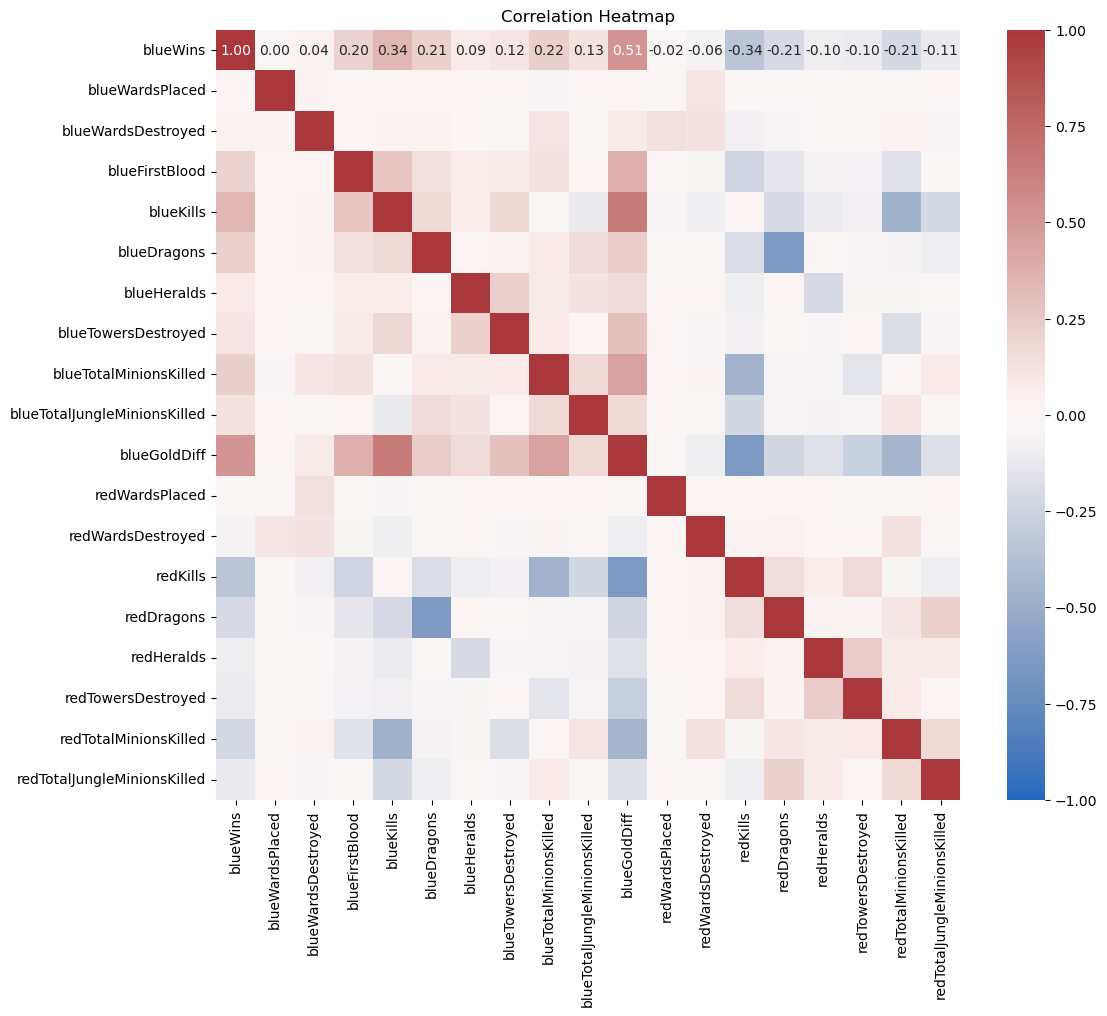

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

blue_side_columns = [col for col in df.columns]

# preparing the data for correlation (vectorize the features)
assembler = VectorAssembler(inputCols=blue_side_columns, outputCol="features")
df_corr = assembler.transform(df)

correlation_matrix = Correlation.corr(df_corr, "features").head()[0]

# conv the correlation matrix to a Pandas DataFrame
correlation_matrix = correlation_matrix.toArray()
corr_df = pd.DataFrame(correlation_matrix, columns=blue_side_columns, index=blue_side_columns)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap='vlag', annot=True, fmt='.2f', vmin=-1)
plt.title("Correlation Heatmap")
plt.show()


In [11]:
# In regards of these informations, we modify or drop some features :

# Assits & Kills are added together
# EliteMonsters is dropped : we already have this information with Dragon & Helder
# Everything relative to gold is dropped, because a lot of actions in game allow player to earn gold. We will focus on which decisions has to be taken to result in a potential win. We could study the influence of gold later
# Everything relative to experience will be dropped for the same reason
# CsPerMin is dropped : before 10 min, it is not relevant. We keep TotalCS instead
# We keep AvgLevel because of the relative low correlation with others features except gold we have removed

In [12]:
# We note some outliers

# * blueWardsPlaced
# * blueWardsDestroyed
# * blueDeath
# * blueTowerDestroyed
# * KA

In [13]:
import numpy as np

array([[<Axes: title={'center': 'blueWins'}>,
        <Axes: title={'center': 'blueWardsPlaced'}>,
        <Axes: title={'center': 'blueWardsDestroyed'}>],
       [<Axes: title={'center': 'blueFirstBlood'}>,
        <Axes: title={'center': 'blueKills'}>,
        <Axes: title={'center': 'blueDragons'}>],
       [<Axes: title={'center': 'blueHeralds'}>,
        <Axes: title={'center': 'blueTowersDestroyed'}>,
        <Axes: title={'center': 'blueTotalMinionsKilled'}>]], dtype=object)

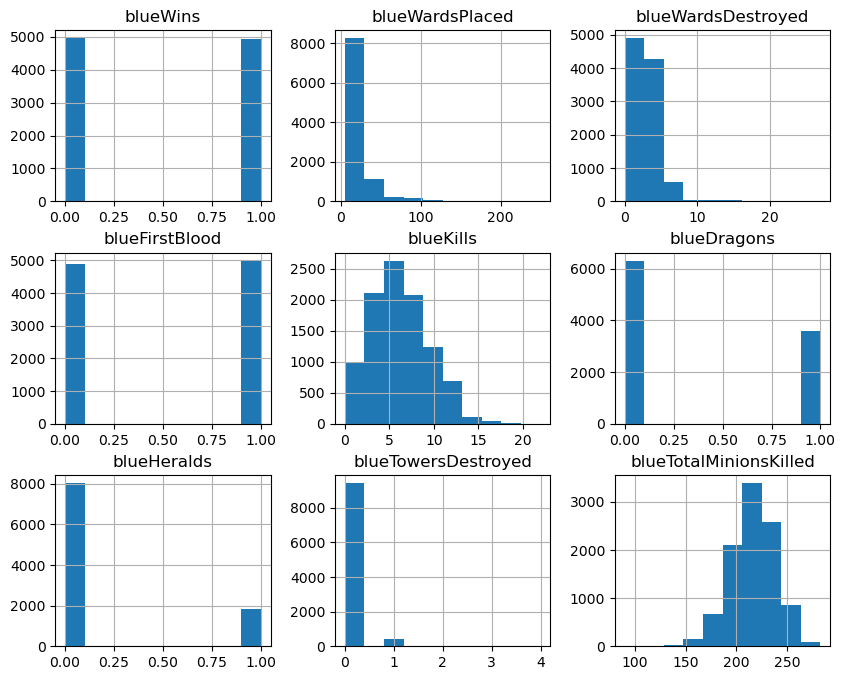

In [14]:
df.toPandas().hist(df.columns[:9],bins=10,figsize=(10, 8))

array([[<Axes: title={'center': 'blueTotalJungleMinionsKilled'}>,
        <Axes: title={'center': 'blueGoldDiff'}>,
        <Axes: title={'center': 'redWardsPlaced'}>],
       [<Axes: title={'center': 'redWardsDestroyed'}>,
        <Axes: title={'center': 'redKills'}>,
        <Axes: title={'center': 'redDragons'}>],
       [<Axes: title={'center': 'redHeralds'}>,
        <Axes: title={'center': 'redTowersDestroyed'}>,
        <Axes: title={'center': 'redTotalMinionsKilled'}>],
       [<Axes: title={'center': 'redTotalJungleMinionsKilled'}>,
        <Axes: >, <Axes: >]], dtype=object)

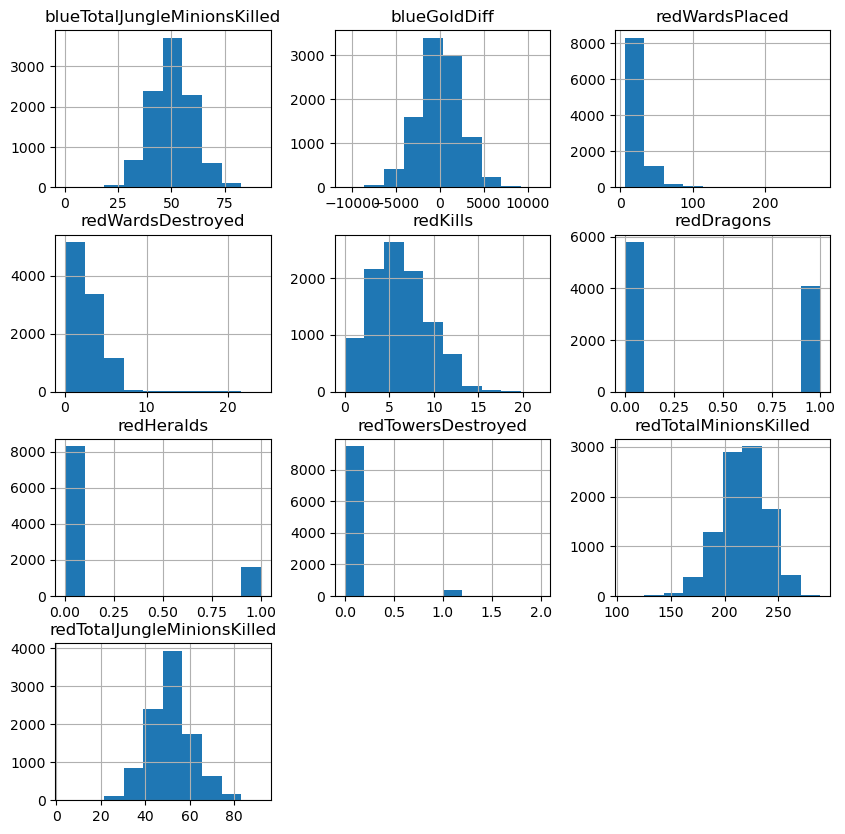

In [15]:
df.toPandas().hist(df.columns[9:],bins=10,figsize=(10, 10))

In [16]:
df_no_outliers = df
df_no_outliers.columns

['blueWins',
 'blueWardsPlaced',
 'blueWardsDestroyed',
 'blueFirstBlood',
 'blueKills',
 'blueDragons',
 'blueHeralds',
 'blueTowersDestroyed',
 'blueTotalMinionsKilled',
 'blueTotalJungleMinionsKilled',
 'blueGoldDiff',
 'redWardsPlaced',
 'redWardsDestroyed',
 'redKills',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'redTotalMinionsKilled',
 'redTotalJungleMinionsKilled']

c:\Users\48692\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


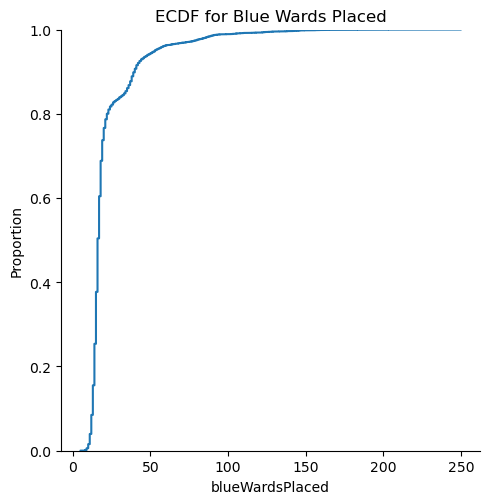

In [17]:
# ECDF for blueWardsPlaced
blue_wards_placed_pd = df_no_outliers.select('blueWardsPlaced').toPandas()
sns.displot(blue_wards_placed_pd['blueWardsPlaced'], kind="ecdf")
plt.title("ECDF for Blue Wards Placed")
plt.show()

In [18]:
from pyspark.sql import functions as F

# Start with the original blue_data DataFrame
df_no_outliers = df

# Filter for blueWardsPlaced
percentile_99 = df_no_outliers.approxQuantile('blueWardsPlaced', [0.99], 0.001)[0]
df_no_outliers = df_no_outliers.filter(
    df_no_outliers['blueWardsPlaced'] <= percentile_99
)
print(f"After filtering blueWardsPlaced, {df_no_outliers.count()} rows remain.")

# Filter for blueWardsDestroyed
percentile_99 = df_no_outliers.approxQuantile('redWardsPlaced', [0.99], 0.001)[0]
df_no_outliers = df_no_outliers.filter(
    df_no_outliers['redWardsPlaced'] <= percentile_99
)
print(f"After filtering redWardsPlaced, {df_no_outliers.count()} rows remain.")



df_no_outliers.columns



After filtering blueWardsPlaced, 9771 rows remain.
After filtering redWardsPlaced, 9666 rows remain.


['blueWins',
 'blueWardsPlaced',
 'blueWardsDestroyed',
 'blueFirstBlood',
 'blueKills',
 'blueDragons',
 'blueHeralds',
 'blueTowersDestroyed',
 'blueTotalMinionsKilled',
 'blueTotalJungleMinionsKilled',
 'blueGoldDiff',
 'redWardsPlaced',
 'redWardsDestroyed',
 'redKills',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'redTotalMinionsKilled',
 'redTotalJungleMinionsKilled']

In [19]:
# Target balance
df_balanced = df_no_outliers

In [20]:
from pyspark.sql.functions import col

In [21]:
# To create a relevant model, let's check if the target is well balanced between 0 & 1

# Total number of games and the number of won games (where 'blueWins' = 1)
total_games = df_balanced.count()
won_games = df_balanced.filter(col('blueWins') == 1).count()

won_percentage = (won_games / total_games) * 100

print(f"In this current Dataset, there is {won_percentage:.3f}% of won games")


In this current Dataset, there is 49.948% of won games


In [22]:
# Target: 'blueWins'
target = df_balanced.select('blueWins')

# Features: everything else
features = df_balanced.drop('blueWins')


In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator


feature_columns = features.columns

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data_assembled = assembler.transform(df)
print(data_assembled)


DataFrame[blueWins: int, blueWardsPlaced: int, blueWardsDestroyed: int, blueFirstBlood: int, blueKills: int, blueDragons: int, blueHeralds: int, blueTowersDestroyed: int, blueTotalMinionsKilled: int, blueTotalJungleMinionsKilled: int, blueGoldDiff: int, redWardsPlaced: int, redWardsDestroyed: int, redKills: int, redDragons: int, redHeralds: int, redTowersDestroyed: int, redTotalMinionsKilled: int, redTotalJungleMinionsKilled: int, features: vector]


In [24]:

# Standardization
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)
# Split data
train_data, test_data = data_scaled.randomSplit([0.9, 0.1], seed=42)

# Train Logistic Reg
log_reg = LogisticRegression(featuresCol="scaled_features", labelCol="blueWins")  # Assuming 'blueWins' is the target column

# Train model
log_reg_model = log_reg.fit(train_data)

# Accuracy
accuracy_reg = log_reg_model.evaluate(test_data).accuracy
print(f"Accuracy: {accuracy_reg * 100:.2f}%")

coefficients = log_reg_model.coefficients
features = feature_columns

feature_weights = pd.DataFrame({
    'Features': features,
    'Weights': coefficients.toArray()
})

feature_weights = feature_weights.sort_values(by='Weights', ascending=False)

print(feature_weights)



Accuracy: 71.60%
                        Features   Weights
9                   blueGoldDiff  1.392541
4                    blueDragons  0.164058
8   blueTotalJungleMinionsKilled  0.108257
15            redTowersDestroyed  0.100574
5                    blueHeralds  0.035663
16         redTotalMinionsKilled  0.027902
3                      blueKills  0.026440
1             blueWardsDestroyed  0.002759
11             redWardsDestroyed  0.000103
7         blueTotalMinionsKilled -0.007753
2                 blueFirstBlood -0.020157
12                      redKills -0.020706
14                    redHeralds -0.027042
0                blueWardsPlaced -0.030514
17   redTotalJungleMinionsKilled -0.038882
10                redWardsPlaced -0.047627
6            blueTowersDestroyed -0.063147
13                    redDragons -0.129158


In [25]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns

# evaluator for AUC metric
evaluator = BinaryClassificationEvaluator(labelCol="blueWins", metricName="areaUnderROC")
# area under the ROC curve 0 to 1.
# 0.5: no better than random guessing.
# 1.0: perfectly classifies

# Logistic Regression
accuracy_reg = log_reg_model.evaluate(test_data).accuracy
print(f"Accuracy: {accuracy_reg * 100:.2f}%")

# Random Forest Model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="blueWins")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc * 100:.2f}%")

# Gradient Boosted Trees Model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="blueWins", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees AUC: {gbt_auc * 100:.2f}%")

# Decision Tree Model
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="blueWins")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC: {dt_auc * 100:.2f}%")

# Multilayer Perceptron Model
layers = [len(feature_columns), 10, 5, 2]
mlp = MultilayerPerceptronClassifier(featuresCol="scaled_features", labelCol="blueWins", layers=layers, seed=42)
mlp_model = mlp.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)
mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"Multilayer Perceptron AUC: {mlp_auc * 100:.2f}%")

# Naive Bayes Model
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(data_assembled)
data_scaled_nb = scaler_model.transform(data_assembled)

train_data_nb, test_data_nb = data_scaled_nb.randomSplit([0.9, 0.1], seed=42)
nb = NaiveBayes(featuresCol="scaled_features", labelCol="blueWins")
nb_model = nb.fit(train_data_nb)
nb_predictions = nb_model.transform(test_data_nb)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes AUC: {nb_auc * 100:.2f}%")


Accuracy: 71.60%
Random Forest AUC: 79.11%
Gradient Boosted Trees AUC: 78.67%
Decision Tree AUC: 77.03%
Multilayer Perceptron AUC: 78.07%
Naive Bayes AUC: 45.38%


c:\Users\48692\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


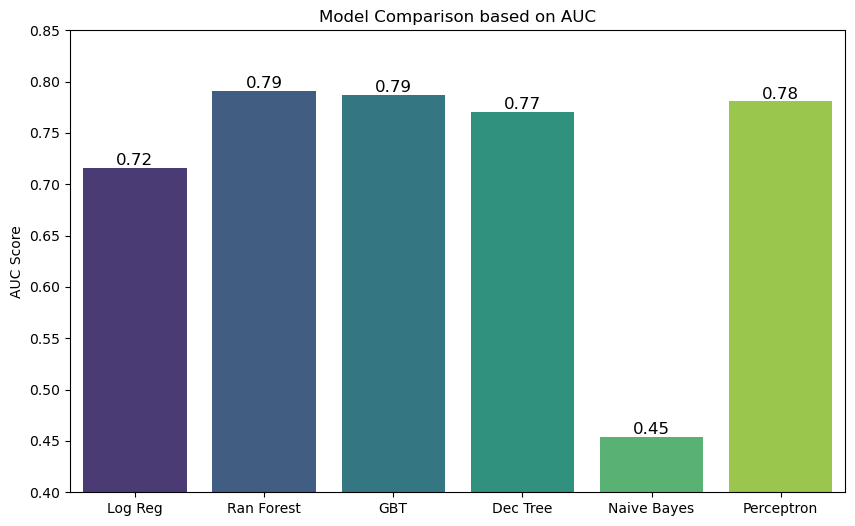

In [26]:
models = ["Log Reg", "Ran Forest", "GBT", "Dec Tree", "Naive Bayes", "Perceptron"]
auc_scores = [accuracy_reg, rf_auc, gbt_auc, dt_auc, nb_auc, mlp_auc]

# For comparison in report
plt.figure(figsize=(10,6))
plt.ylim(0.4, 0.85)
sns.barplot(x=models, y=auc_scores, palette="viridis")

for i, auc in enumerate(auc_scores):
    plt.text(i, auc, f'{auc:.2f}', ha='center', va='bottom', fontsize=12, color='black')

plt.title('Model Comparison based on AUC')
plt.ylabel('AUC Score')
plt.show()

In [27]:
# Hyperparameters tuning

# Log Regression
# param_grid = ParamGridBuilder() \
#     .addGrid(log_reg.regParam, [0.1, 0.01, 0.001]) \
#     .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .addGrid(log_reg.maxIter, [10, 20, 50]) \
#     .build()

# cv_reg = CrossValidator(estimator=log_reg, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10) # 3 # 5
# cv_reg_model = cv_reg.fit(train_data)
# cv_reg_predictions = cv_reg_model.transform(test_data)
# cv_reg_auc = evaluator.evaluate(cv_reg_predictions)
# print(f"Tuned Logistic Regression AUC: {cv_reg_auc * 100:.2f}%")


# Random Forest
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=3)
cv_rf_model = cv_rf.fit(train_data)
cv_rf_predictions = cv_rf_model.transform(test_data)
cv_rf_auc = evaluator.evaluate(cv_rf_predictions)
print(f"Tuned Random Forest AUC: {cv_rf_auc * 100:.2f}%")


# Gradient Boosted Trees
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxIter, [20, 50, 100]) \
    .build()

cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=3)
cv_gbt_model = cv_gbt.fit(train_data)
cv_gbt_predictions = cv_gbt_model.transform(test_data)
cv_gbt_auc = evaluator.evaluate(cv_gbt_predictions)
print(f"Tuned Gradient Boosted Trees AUC: {cv_gbt_auc * 100:.2f}%")

# Decision Tree
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .build()

cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=param_grid_dt, evaluator=evaluator, numFolds=3)
cv_dt_model = cv_dt.fit(train_data)
cv_dt_predictions = cv_dt_model.transform(test_data)
cv_dt_auc = evaluator.evaluate(cv_dt_predictions)
print(f"Tuned Decision Tree AUC: {cv_dt_auc * 100:.2f}%")

# Bayes out

# Multilayer Perceptron
param_grid_mlp = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.01, 0.1, 0.5]) \
    .build()

cv_mlp = CrossValidator(estimator=mlp, estimatorParamMaps=param_grid_mlp, evaluator=evaluator, numFolds=3)
cv_mlp_model = cv_mlp.fit(train_data)
cv_mlp_predictions = cv_mlp_model.transform(test_data)
cv_mlp_auc = evaluator.evaluate(cv_mlp_predictions)
print(f"Tuned Multilayer Perceptron AUC: {cv_mlp_auc * 100:.2f}%")

Tuned Random Forest AUC: 79.61%
Tuned Gradient Boosted Trees AUC: 79.22%
Tuned Decision Tree AUC: 77.03%
Tuned Multilayer Perceptron AUC: 79.05%


c:\Users\48692\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


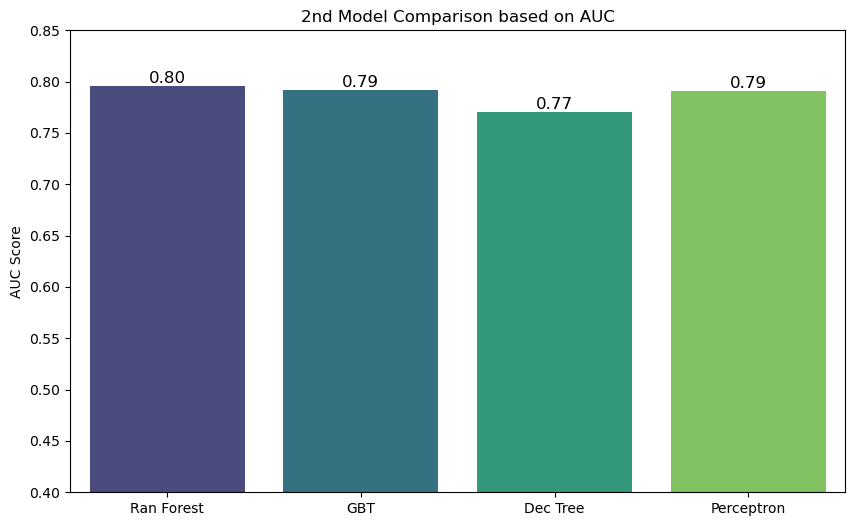

In [30]:
models = ["Ran Forest", "GBT", "Dec Tree", "Perceptron"]
auc_scores = [cv_rf_auc, cv_gbt_auc, cv_dt_auc, cv_mlp_auc]

plt.figure(figsize=(10,6))
plt.ylim(0.4, 0.85)
sns.barplot(x=models, y=auc_scores, palette="viridis")

for i, auc in enumerate(auc_scores):
    plt.text(i, auc, f'{auc:.2f}', ha='center', va='bottom', fontsize=12, color='black')

plt.title('2nd Model Comparison based on AUC')
plt.ylabel('AUC Score')
plt.show()

Feature Importances for Random Forest Model (Sorted):
blueGoldDiff: 0.5533
blueKills: 0.1300
redKills: 0.1213
blueDragons: 0.0404
redDragons: 0.0388
blueTotalMinionsKilled: 0.0326
blueFirstBlood: 0.0252
redTotalMinionsKilled: 0.0238
blueTotalJungleMinionsKilled: 0.0151
redTotalJungleMinionsKilled: 0.0049
redWardsPlaced: 0.0029
blueWardsPlaced: 0.0029
redWardsDestroyed: 0.0023
blueTowersDestroyed: 0.0021
blueWardsDestroyed: 0.0017
blueHeralds: 0.0011
redTowersDestroyed: 0.0009
redHeralds: 0.0009


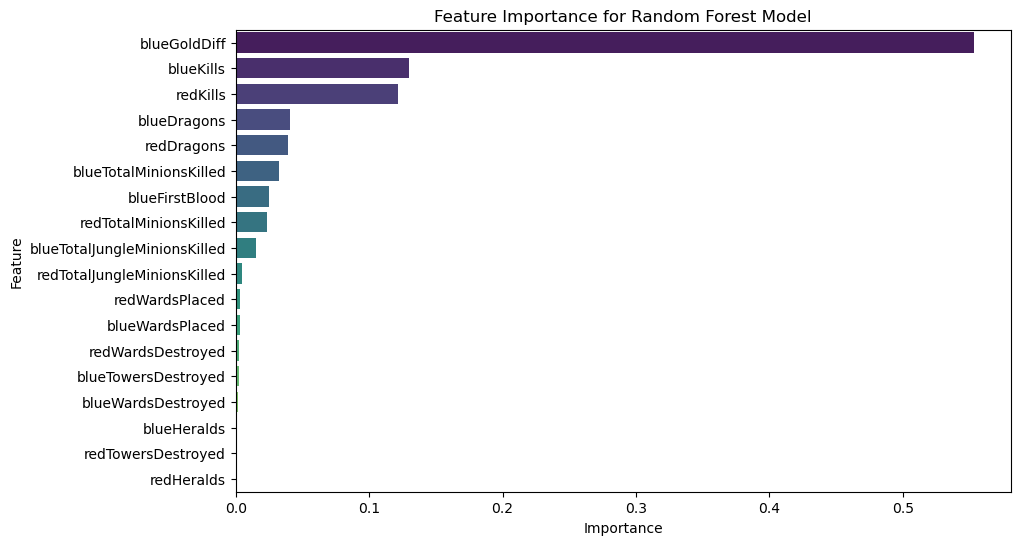

In [46]:
# For Random Forest model
cv_rf_model = cv_rf_model.bestModel
rf_feature_importance = cv_rf_model.featureImportances.toArray()
feature_names = feature_columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances for Random Forest Model (Sorted):")
for index, row in feature_importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title('Feature Importance for Random Forest Model')
plt.show()


In [31]:
from pyspark.sql import functions as F

# probabilities for important features

# blue winning if they have a significant gold difference
gold_diff_win = df_no_outliers.filter(col('blueGoldDiff') >= 1000) \
    .agg(F.avg('blueWins').alias('gold_diff_win_rate')).collect()[0]['gold_diff_win_rate']

print(f"The probability of the blue team winning when blueGoldDiff is >= 1000 is about {1 - gold_diff_win:.4f}")

# blue winning if they have more kills
blue_kills_win = df_no_outliers.filter(col('blueKills') > col('redKills')) \
    .agg(F.avg('blueWins').alias('blue_kills_win_rate')).collect()[0]['blue_kills_win_rate']

print(f"The probability of the blue team winning when blueKills > redKills is about {blue_kills_win:.4f}")

# blue winning if they have more dragons
blue_dragons_win = df_no_outliers.filter(col('blueDragons') > col('redDragons')) \
    .agg(F.avg('blueWins').alias('blue_dragons_win_rate')).collect()[0]['blue_dragons_win_rate']

print(f"The probability of the blue team winning when blueDragons > redDragons is about {blue_dragons_win:.4f}")

# blue winning when they secured the First Blood
blue_first_blood_win = df_no_outliers.filter(col('blueFirstBlood') == 1) \
    .agg(F.avg('blueWins').alias('blue_first_blood_win_rate')).collect()[0]['blue_first_blood_win_rate']

print(f"The probability of the blue team winning when they got First Blood is about {blue_first_blood_win:.4f}")

# blue winning if they have destroyed more turrets
blue_turrets_win = df_no_outliers.filter(col('blueTowersDestroyed') > col('redTowersDestroyed')) \
    .agg(F.avg('blueWins').alias('blue_turrets_win_rate')).collect()[0]['blue_turrets_win_rate']

print(f"The probability of the blue team winning when they destroyed more turrets than red team is about {blue_turrets_win:.4f}")

# blue winning if they destroyed more wards
blue_wards_destroyed_win = df_no_outliers.filter(col('blueWardsDestroyed') > col('redWardsDestroyed')) \
    .agg(F.avg('blueWins').alias('blue_wards_destroyed_win_rate')).collect()[0]['blue_wards_destroyed_win_rate']

print(f"The probability of the blue team winning when they destroyed more wards than red team is about {blue_wards_destroyed_win:.4f}")


The probability of the blue team winning when blueGoldDiff is >= 1000 is about 0.2020
The probability of the blue team winning when blueKills > redKills is about 0.7242
The probability of the blue team winning when blueDragons > redDragons is about 0.6417
The probability of the blue team winning when they got First Blood is about 0.6001
The probability of the blue team winning when they destroyed more turrets than red team is about 0.7611
The probability of the blue team winning when they destroyed more wards than red team is about 0.5460


In [32]:
from pyspark.sql import functions as F

# winning with 0, 1, and 2 turrets destroyed
blue_turrets_win = df_no_outliers.groupBy('blueTowersDestroyed').agg(
    F.avg('blueWins').alias('win_rate')).orderBy('blueTowersDestroyed')

print("The probability to win based on turrets destroyed at 10 minutes:")
blue_turrets_win.show()

# blue winning with 0, 1, and 2 drakes
blue_drakes_win = df_no_outliers.groupBy('blueDragons').agg(
    F.avg('blueWins').alias('win_rate')).orderBy('blueDragons')

print("The probability to win based on drakes taken at 10 minutes:")
blue_drakes_win.show()

# blue winning with 0, 1, and 2 heralds
blue_heralds_win = df_no_outliers.groupBy('blueHeralds').agg(
    F.avg('blueWins').alias('win_rate')).orderBy('blueHeralds')

print("The probability to win based on heralds taken at 10 minutes:")
blue_heralds_win.show()

# probability of winning with different warding scenarios
median_wards_placed = df_no_outliers.approxQuantile('blueWardsPlaced', [0.5], 0.001)[0]
median_wards_destroyed = df_no_outliers.approxQuantile('blueWardsDestroyed', [0.5], 0.001)[0]

print(f"Median wards placed: {median_wards_placed}")
print(f"Median wards destroyed: {median_wards_destroyed}")

# winning with high vs low warding (based on median)
high_warding_win = df_no_outliers.filter(col("blueWardsPlaced") >= median_wards_placed) \
    .agg(F.avg("blueWins").alias("high_warding_win_rate")).collect()[0]['high_warding_win_rate']
low_warding_win = df_no_outliers.filter(col("blueWardsPlaced") < median_wards_placed) \
    .agg(F.avg("blueWins").alias("low_warding_win_rate")).collect()[0]['low_warding_win_rate']

print(f"Win rate for high warding teams: {high_warding_win:.4f}")
print(f"Win rate for low warding teams: {low_warding_win:.4f}")

high_ward_destruction_win = df_no_outliers.filter(col("blueWardsDestroyed") >= median_wards_destroyed) \
    .agg(F.avg("blueWins").alias("high_ward_destruction_win_rate")).collect()[0]['high_ward_destruction_win_rate']
low_ward_destruction_win = df_no_outliers.filter(col("blueWardsDestroyed") < median_wards_destroyed) \
    .agg(F.avg("blueWins").alias("low_ward_destruction_win_rate")).collect()[0]['low_ward_destruction_win_rate']

print(f"Win rate for high ward destruction teams: {high_ward_destruction_win:.4f}")
print(f"Win rate for low ward destruction teams: {low_ward_destruction_win:.4f}")

print(f"The probability of winning with 0 turrets at 10 minutes is {blue_turrets_win.filter(col('blueTowersDestroyed') == 0).collect()[0]['win_rate']:.4f}")
print(f"The probability of winning with 1 turret at 10 minutes is {blue_turrets_win.filter(col('blueTowersDestroyed') == 1).collect()[0]['win_rate']:.4f}")
print(f"The probability of winning with 2 turrets at 10 minutes is {blue_turrets_win.filter(col('blueTowersDestroyed') == 2).collect()[0]['win_rate']:.4f}")


The probability to win based on turrets destroyed at 10 minutes:
+-------------------+-------------------+
|blueTowersDestroyed|           win_rate|
+-------------------+-------------------+
|                  0|0.48692633177823585|
|                  1| 0.7397590361445783|
|                  2| 0.9629629629629629|
|                  3|                1.0|
|                  4|                1.0|
+-------------------+-------------------+

The probability to win based on drakes taken at 10 minutes:
+-----------+------------------+
|blueDragons|          win_rate|
+-----------+------------------+
|          0|0.4187479727538112|
|          1|0.6417142857142857|
+-----------+------------------+

The probability to win based on heralds taken at 10 minutes:
+-----------+------------------+
|blueHeralds|          win_rate|
+-----------+------------------+
|          0|0.4776347648782974|
|          1|0.5937328202308961|
+-----------+------------------+

Median wards placed: 16.0
Median ward

In [ ]:
# log_reg_model.save("test")

In [ ]:
# log_reg_model.transform(data_scaled)["prediction","blueWins"].show()

In [ ]:
# scaler_model.save("scale_test")

In [33]:
from pyspark.ml import PipelineModel

best_rf_model = cv_rf_model.bestModel

pipeline_rf = Pipeline(stages=[
    VectorAssembler(inputCols=feature_columns, outputCol='assembled_features'),
    StandardScaler(inputCol="assembled_features", outputCol="pipeline_scaled_features", withStd=True, withMean=True),
    best_rf_model
])

pipeline_rf_model = pipeline_rf.fit(train_data)
pipeline_rf_predictions = pipeline_rf_model.transform(test_data)

pipeline_rf_predictions.select("prediction", "blueWins").show()

pipeline_rf_model.save("/save_pipeline_somewhere_auu")

+----------+--------+
|prediction|blueWins|
+----------+--------+
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
+----------+--------+
only showing top 20 rows



Py4JJavaError: An error occurred while calling o30253.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1623)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1623)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1609)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1609)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 68 more


In [34]:
loaded_pipeline_rf_model = PipelineModel.load("/save_pipeline_somewhere_auu")

# check
loaded_predictions = loaded_pipeline_rf_model.transform(test_data)
loaded_predictions.select("prediction", "blueWins").show()

Py4JJavaError: An error occurred while calling o30261.partitions.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.FileSystem$4.<init>(FileSystem.java:2180)
	at org.apache.hadoop.fs.FileSystem.listLocatedStatus(FileSystem.java:2179)
	at org.apache.hadoop.fs.ChecksumFileSystem.listLocatedStatus(ChecksumFileSystem.java:783)
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:285)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:208)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.api.java.JavaRDDLike.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.JavaRDDLike.partitions$(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
